# Entropic estimation of optimal transport maps

We experiment with the 

The idea ...

Setting : 2-samples estimates

*copié de la page 9*

The article proposes the following estimator of the map :
$$T_{\varepsilon,(n, n)}(x)=\frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}{\frac{1}{n} \sum_{i=1}^n e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}$$
where $g_{\varepsilon,(n, n)}$ is the entropic potential corresponding to $Q_n$ in the optimal entropic plan between $P_n$ and $Q_n$, obtained by the ouput of Sinkhorn algo..

In [8]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [9]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.geometry.costs import SqPNorm
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot

In [10]:
def create_points(rng, n, T): # T must be a monotone scalar function !
    rngs = jax.random.split(rng, 2)

    x = jax.random.uniform(rngs[0], (n,2), minval = -1, maxval = 1)
    z = jax.random.uniform(rngs[1], (n,2), minval = -1, maxval = 1)

    y = T(z)
    
    return x, y

Create a {class}`~ott.problems.linear.linear_problem.LinearProblem` comparing two {class}`point clouds <ott.geometry.pointcloud.PointCloud>`.

In [153]:
from ott.geometry.costs import SqEuclidean
rng = jax.random.PRNGKey(0)
T = lambda x : 3 * x**2 * jnp.sign(x) # jnp.log(1.2 + x) #
n = 500
x,y = create_points(rng, n, T)
epsilon = 1e-1 /2

geom = pointcloud.PointCloud(x, y, cost_fn = SqEuclidean() , epsilon = epsilon) # vérifier que ma cost_fn est la bonne !
ot_prob = linear_problem.LinearProblem(geom)

In [154]:
solver = sinkhorn.Sinkhorn()
ot_sink = solver(ot_prob)

In [155]:
ot_sink.ot_prob.geom.y.shape

(500, 2)

In [156]:
c = SqPNorm(2)

In [157]:
def entropic_map_estimator_ONE_sample(ot_sink):
    g = ot_sink.g[:,None]
    Y = ot_sink.ot_prob.geom.y
    epsilon = ot_sink.ot_prob.geom.epsilon

    
    #print("1", c.pairwise(, Y))
    #print("manually", 

    numerator = lambda x : jnp.mean(Y * jnp.exp(1/epsilon * (g - 0.5 * jnp.linalg.norm(x - Y, ord=2, axis = 1, keepdims=True)**2)), axis = 0)
    denominator = lambda x : jnp.mean(  jnp.exp(1/epsilon * (g - 0.5 * jnp.linalg.norm(x - Y, ord=2, axis = 1, keepdims=True)**2)), axis = 0)


    T_hat = lambda x : numerator(x)/denominator(x)

    T_hat = jax.vmap(lambda x : numerator(x)/denominator(x))

    return T_hat

In [158]:
def entropic_map_estimator_TWO_sample(ot_sink):
    entropic_obj = ot_sink.to_dual_potentials()
    print("entropic", entropic_obj.g)


    # g = ot_sink.g[:,None]
    # Y = ot_sink.ot_prob.geom.y
    # epsilon = ot_sink.ot_prob.geom.epsilon

    # g = entropic_obj.g

    # epsilon = entropic_obj.epsilon

    # numerator = lambda x : jnp.mean(Y * jnp.exp(1/epsilon * (g(Y)[:, None] - 0.5 * jnp.linalg.norm(x - Y, ord=2, axis = 1, keepdims=True)**2)), axis = 0)
    # denominator = lambda x : jnp.mean(  jnp.exp(1/epsilon * (g(Y)[:, None] - 0.5 * jnp.linalg.norm(x - Y, ord=2, axis = 1, keepdims=True)**2)), axis = 0)


    T_hat = lambda x : numerator(x)/denominator(x)
    T_hat = jax.vmap(lambda x : numerator(x)/denominator(x))

    return T_hat

entropic Partial(<function EntropicPotentials._potential_fn.<locals>.callback at 0x376af77e0>, potential=Array([ 2.67061859e-01,  5.83006740e-01, -5.63619375e-01, -2.35930115e-01,
       -4.83300209e-01,  5.51132917e-01,  2.03139096e-01,  5.07663131e-01,
       -2.27367282e-02,  4.49283212e-01,  4.51988608e-01,  5.02178669e-01,
        4.81384069e-01,  4.42709595e-01, -7.30880737e-01,  5.04457235e-01,
        1.71139240e-01,  2.96699792e-01,  1.32206380e-01,  4.61104423e-01,
        4.37255174e-01,  5.61552167e-01,  4.71233040e-01,  6.37264848e-01,
        4.70337898e-01, -1.70418322e-01, -5.14491200e-01, -4.55639750e-01,
        1.59147620e-01,  4.91345674e-01,  4.39462930e-01, -6.71057463e-01,
        4.95571882e-01,  3.34322363e-01,  5.61703682e-01,  3.55871022e-02,
        1.32427931e-01,  5.76540828e-01,  4.03999478e-01,  3.31429541e-02,
        4.90125567e-01,  3.53458792e-01, -6.74765825e-01,  1.58940852e-02,
       -6.68500900e-01,  4.94276792e-01,  5.69581747e-01, -3.85930270e

[]

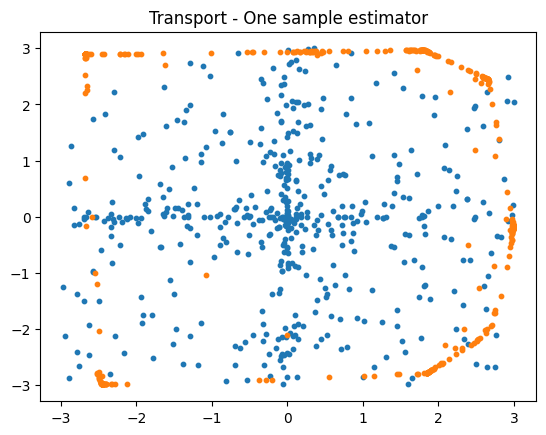

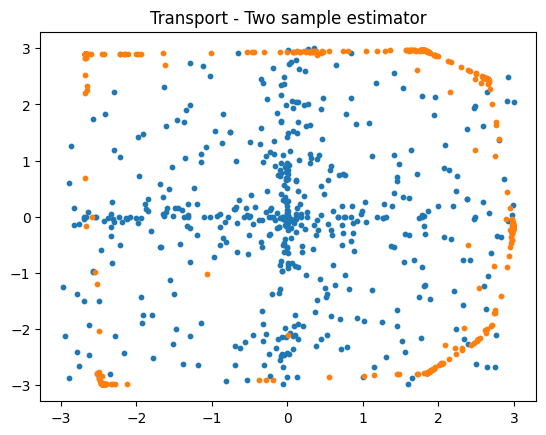

In [159]:
T_hat_1 = entropic_map_estimator_ONE_sample(ot_sink = ot_sink)
T_hat_2 = entropic_map_estimator_TWO_sample(ot_sink = ot_sink)

rng = jax.random.PRNGKey(1)
x_tilde, _ = create_points(rng, n, T)

y_tilde = T(x_tilde)
y_tilde_estimated_1 = T_hat_1(x_tilde)
y_tilde_estimated_2 = T_hat_2(x_tilde)

plt.figure()
plt.plot()
plt.scatter(y_tilde[:,0], y_tilde[:,1], s = 10)
plt.scatter(y_tilde_estimated_1[:,0], y_tilde_estimated_1[:,1], s = 10)
plt.title("Transport - One sample estimator")
plt.plot()

plt.figure()
plt.plot()
plt.scatter(y_tilde[:,0], y_tilde[:,1], s = 10)
plt.scatter(y_tilde_estimated_2[:,0], y_tilde_estimated_2[:,1], s = 10)
plt.title("Transport - Two sample estimator")
plt.plot()


# Fin

In [144]:
from mpl_toolkits.mplot3d import Axes3D

tab = jnp.arange(-1,1,0.25)
X,Y = jnp.meshgrid(tab ,tab)

print(X.shape)
print(Y.shape)
print(jnp.concatenate((X[:,None],Y[:,None]), axis = 1))
Z,_ = T()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')


(8, 8)
(8, 8)
[[[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.  ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-0.75 -0.75 -0.75 -0.75 -0.75 -0.75 -0.75 -0.75]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5 ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5 ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75]]]


TypeError: <lambda>() missing 1 required positional argument: 'x'

In [145]:
X

Array([[-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75]],      dtype=float32)